# Notebook to Normalize Crash Hotspots by traffic density
the idea is to get a normalized Hotpsot indication, i.e. the crash exposure relative to the amount of traffic on that link should be determined

In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, Point
import numpy as np

### Load the required data 

In [2]:
zaehlstelle = gpd.read_file('Files/Jawe2021_us.csv')

In [41]:
unfallorte = gpd.read_file("Files/unfallorte_2022_HW_mapmatched_ref_DBSCAN_same_HW.shp")

In [46]:
def convert_float(value):
    try: 
        return float(value)
    except ValueError:
        return np.nan

In [47]:
zaehlstelle[['DTV_Kfz_MobisSo_Q', 'Koor_WGS84_N', 'Koor_WGS84_E']] = zaehlstelle[['DTV_Kfz_MobisSo_Q', 'Koor_WGS84_N', 'Koor_WGS84_E']].applymap(convert_float)

## Create Geometries from datframe 

In [48]:
geometry = [Point(Koor_WGS84_E, Koor_WGS84_N) for Koor_WGS84_E, Koor_WGS84_N in zip(zaehlstelle['Koor_WGS84_E'], zaehlstelle['Koor_WGS84_N'])]
gdf_zaehlstelle = gpd.GeoDataFrame(zaehlstelle, geometry=geometry, crs="EPSG:4326")

### Filter to relevant area 

In [49]:
gdf_zaehlstelle = gdf_zaehlstelle[(gdf_zaehlstelle['Koor_WGS84_E']<16) & (gdf_zaehlstelle['Koor_WGS84_N']>46)]

In [50]:
def haversine(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    # Radius of the Earth in meters
    R = 6371000.0  # Approximately 6,371,000 meters

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Calculate the distance in meters
    distance = R * c

    return distance

In [51]:
from geopy.distance import geodesic

def next_messtelle(row1, gdf_zaehlstelle):
    # Iterate through each row in gdf1
    
    min_distance = float('inf')  # Initialize with positive infinity
    nearest_messetelle = None
    nearest_verkehrsstaerke = None
    nearest_gemeinde = None
    n_lat = None
    n_lon = None
    # Iterate through each row in gdf2
    for idx, row2 in gdf_zaehlstelle.iterrows():

        # Calculate the minimum Haversine distance between each coordinate point in the LineString and the point in gdf1
        line_distance = haversine((row1['lat'],row1['lon']), (row2['Koor_WGS84_N'], row2['Koor_WGS84_E']))
        # Check if this row has a smaller distance than the current minimum
        #print (row1['lat'],row1['lon'], row2['Koor_WGS84_N'], row2['Koor_WGS84_E'])
        if line_distance < min_distance:
            #if not np.isnan(row2['DTV_Kfz_MobisSo_Q']):
            if row2['Str_Kl']+' '+ row2['Str_Nr']== row1['ref_y']:
                #print(row2['Str_Kl']+' '+ row2['Str_Nr']== row1['ref_y'])
                min_distance = line_distance
                nearest_messetelle = row2['DZ_Nr']
                nearest_verkehrsstaerke = row2['DTV_Kfz_MobisSo_Q']
                nearest_gemeinde = row2['DZ_Name']
                n_lat = row2['Koor_WGS84_N']
                n_lon = row2['Koor_WGS84_E']
        # Print the nearest "osm_id" and the Haversine distance for each point in gdf1
    print (row1['lat'],row1['lon'], n_lat, n_lon)
    print(f"For point at index {idx}, Nearest Messtelle: {nearest_messetelle}, verkehrsstaerke: {nearest_verkehrsstaerke}")
    print("Haversine Distance (meters):", min_distance, f"UGEMEINDE: {row1['UGEMEINDE']}, Z_Gem: {nearest_gemeinde}, HW: {row1['ref_y']}")
    return nearest_messetelle, min_distance, nearest_verkehrsstaerke

In [52]:
import math
results_ms = unfallorte.apply(lambda row: next_messtelle(row, gdf_zaehlstelle), axis=1)

# Create two separate lists to hold the results
nearest_messetelle, min_distance, nearest_verkehrsstaerke = zip(*results_ms)

# Add the lists as new columns to the points_in_berlin DataFrame
unfallorte['nearest_messetelle'] = nearest_messetelle
unfallorte['distance_MS'] = min_distance
unfallorte['nearest_verkehrsstaerke'] = nearest_verkehrsstaerke


54.225344551 10.900516477 54.29984259 10.88208029
For point at index 2107, Nearest Messtelle: 1124, verkehrsstaerke: 19655.0
Haversine Distance (meters): 8369.890043608417 UGEMEINDE: 027, Z_Gem: Oldenburg (Holstein), HW: A 1
53.821521594 10.527979416 53.8021139 10.44901353
For point at index 2107, Nearest Messtelle: 1291, verkehrsstaerke: nan
Haversine Distance (meters): 5615.627175919611 UGEMEINDE: 094, Z_Gem: Reinfeld, HW: A 1
53.3325978 9.617068882 53.37916596 9.9660325
For point at index 2107, Nearest Messtelle: 3444, verkehrsstaerke: 58235.0
Haversine Distance (meters): 23731.08431236178 UGEMEINDE: 039, Z_Gem: Dibbersen, HW: A 1
54.124344165 10.80794304 54.10379261 10.78102643
For point at index 2107, Nearest Messtelle: 1105, verkehrsstaerke: 26367.0
Haversine Distance (meters): 2881.011894090322 UGEMEINDE: 002, Z_Gem: Neustadt i H-Süd, HW: A 1
54.348886361 10.950553463 54.29984259 10.88208029
For point at index 2107, Nearest Messtelle: 1124, verkehrsstaerke: 19655.0
Haversine Dis

52.615121024 13.543138626 52.61631602 13.52467708
For point at index 2107, Nearest Messtelle: 3667, verkehrsstaerke: nan
Haversine Distance (meters): 1253.4550583824064 UGEMEINDE: 181, Z_Gem: Lindenberg, HW: A 10
52.301628871 12.96669918 52.30069461 13.02329463
For point at index 2107, Nearest Messtelle: 3604, verkehrsstaerke: nan
Haversine Distance (meters): 3849.718144524315 UGEMEINDE: 590, Z_Gem: Michendorf, HW: A 10
52.305828885 13.4245787 52.30730937 13.30201798
For point at index 2107, Nearest Messtelle: 3603, verkehrsstaerke: nan
Haversine Distance (meters): 8334.358816844837 UGEMEINDE: 017, Z_Gem: Ludwigsfelde, HW: A 10
52.703338492 13.207432117 52.70572044 13.16385721
For point at index 2107, Nearest Messtelle: 3606, verkehrsstaerke: nan
Haversine Distance (meters): 2947.8189716307656 UGEMEINDE: 144, Z_Gem: Oranienburg, HW: A 10
52.672841932 13.006373951 52.70572044 13.16385721
For point at index 2107, Nearest Messtelle: 3606, verkehrsstaerke: nan
Haversine Distance (meters): 

52.248650431 13.587763762 52.19603734 13.61529248
For point at index 2107, Nearest Messtelle: 3609, verkehrsstaerke: nan
Haversine Distance (meters): 6143.490806539933 UGEMEINDE: 332, Z_Gem: Motzen, HW: A 13
51.537354817 13.90934743 51.68516824 13.9009718
For point at index 2107, Nearest Messtelle: 3610, verkehrsstaerke: nan
Haversine Distance (meters): 16446.274924086185 UGEMEINDE: 285, Z_Gem: Gollmitz, HW: A 13
51.572454214 13.930821042 51.68516824 13.9009718
For point at index 2107, Nearest Messtelle: 3610, verkehrsstaerke: nan
Haversine Distance (meters): 12701.447433273099 UGEMEINDE: 285, Z_Gem: Gollmitz, HW: A 13
51.880984545 13.875525201 51.68516824 13.9009718
For point at index 2107, Nearest Messtelle: 3610, verkehrsstaerke: nan
Haversine Distance (meters): 21844.02861530175 UGEMEINDE: 196, Z_Gem: Gollmitz, HW: A 13
51.369244204 13.74528593 51.31997542 13.72140948
For point at index 2107, Nearest Messtelle: 4111, verkehrsstaerke: 27972.0
Haversine Distance (meters): 5723.938818

51.76916714 11.671731097 51.7270497 11.67749712
For point at index 2107, Nearest Messtelle: 3832, verkehrsstaerke: nan
Haversine Distance (meters): 4700.038222888258 UGEMEINDE: 030, Z_Gem: Plötzkau, HW: A 14
51.722120809 11.692813012 51.7270497 11.67749712
For point at index 2107, Nearest Messtelle: 3832, verkehrsstaerke: nan
Haversine Distance (meters): 1188.8137815793184 UGEMEINDE: 195, Z_Gem: Plötzkau, HW: A 14
51.841917664 11.676524131 51.7270497 11.67749712
For point at index 2107, Nearest Messtelle: 3832, verkehrsstaerke: nan
Haversine Distance (meters): 12772.910185594452 UGEMEINDE: 235, Z_Gem: Plötzkau, HW: A 14
52.290010532 11.62231604 52.18148202 11.54792478
For point at index 2107, Nearest Messtelle: 3839, verkehrsstaerke: 10460.0
Haversine Distance (meters): 13087.972493930358 UGEMEINDE: 130, Z_Gem: AK Magdeburg Nord, HW: A 14
51.90913386 11.697201119 51.99476192 11.66397969
For point at index 2107, Nearest Messtelle: 3914, verkehrsstaerke: 37187.0
Haversine Distance (meter

52.308627178 10.684430306 52.31175867 10.58555448
For point at index 2107, Nearest Messtelle: 3429, verkehrsstaerke: 74951.0
Haversine Distance (meters): 6730.892678996589 UGEMEINDE: 014, Z_Gem: Braunschweig-Flughafen, HW: A 2
52.22015244 9.087779603 52.22031235 9.03837151
For point at index 2107, Nearest Messtelle: 3496, verkehrsstaerke: 67597.0
Haversine Distance (meters): 3365.781777728311 UGEMEINDE: 036, Z_Gem: Rinteln, HW: A 2
51.944077738 8.544727735 51.94917628 8.55824098
For point at index 2107, Nearest Messtelle: 5120, verkehrsstaerke: 86547.0
Haversine Distance (meters): 1085.9350544472516 UGEMEINDE: 000, Z_Gem: Bielefeld, HW: A 2
51.583612133 7.397450274 51.57507373 7.47744975
For point at index 2107, Nearest Messtelle: 5125, verkehrsstaerke: 88857.0
Haversine Distance (meters): 5608.894676872659 UGEMEINDE: 000, Z_Gem: Waltrop-Brambauer, HW: A 2
52.319212546 12.491535868 52.34067409 12.75021946
For point at index 2107, Nearest Messtelle: 3601, verkehrsstaerke: 53272.0
Havers

54.090171638 13.107256498 53.90513968 13.35014652
For point at index 2107, Nearest Messtelle: 1611, verkehrsstaerke: 14103.0
Haversine Distance (meters): 25987.624282927452 UGEMEINDE: 089, Z_Gem: Jarmen, HW: A 20
53.668643242 13.34577879 53.90513968 13.35014652
For point at index 2107, Nearest Messtelle: 1611, verkehrsstaerke: 14103.0
Haversine Distance (meters): 26298.76935362101 UGEMEINDE: 019, Z_Gem: Jarmen, HW: A 20
53.481494084 13.937543524 53.53174094 13.74491597
For point at index 2107, Nearest Messtelle: 1610, verkehrsstaerke: 13142.0
Haversine Distance (meters): 13910.054847250804 UGEMEINDE: 115, Z_Gem: Strasburg, HW: A 20
53.640718778 13.369862331 53.53174094 13.74491597
For point at index 2107, Nearest Messtelle: 1610, verkehrsstaerke: 13142.0
Haversine Distance (meters): 27562.651955513888 UGEMEINDE: 141, Z_Gem: Strasburg, HW: A 20
53.813873967 13.322796692 53.90513968 13.35014652
For point at index 2107, Nearest Messtelle: 1611, verkehrsstaerke: 14103.0
Haversine Distance 

52.796374299 12.795450781 52.71526434 12.99644805
For point at index 2107, Nearest Messtelle: 3612, verkehrsstaerke: 45029.0
Haversine Distance (meters): 16257.517979795815 UGEMEINDE: 117, Z_Gem: Havelland, HW: A 24
53.127481388 12.460532703 53.17052999 12.34738567
For point at index 2107, Nearest Messtelle: 3611, verkehrsstaerke: 22449.0
Haversine Distance (meters): 8935.766925646316 UGEMEINDE: 181, Z_Gem: Maulbeerwalde, HW: A 24
52.999352603 12.647344516 52.98644625 12.6163697
For point at index 2107, Nearest Messtelle: 3613, verkehrsstaerke: 36132.0
Haversine Distance (meters): 2521.4027659803173 UGEMEINDE: 425, Z_Gem: Netzeband, HW: A 24
53.495983609 11.119591158 53.46328782 11.34192727
For point at index 2107, Nearest Messtelle: 1612, verkehrsstaerke: 25259.0
Haversine Distance (meters): 15155.186746650075 UGEMEINDE: 152, Z_Gem: Hagenow, HW: A 24
53.404126441 11.572647813 53.40780015 11.56723187
For point at index 2107, Nearest Messtelle: 1603, verkehrsstaerke: 25625.0
Haversine D

53.211477036 8.221965788 53.26071591 8.16795102
For point at index 2107, Nearest Messtelle: 3349, verkehrsstaerke: 30579.0
Haversine Distance (meters): 6549.769897213297 UGEMEINDE: 005, Z_Gem: Wemkendorf, HW: A 29
53.501233524 7.996065647 53.47377725 8.01505869
For point at index 2107, Nearest Messtelle: 3451, verkehrsstaerke: 27004.0
Haversine Distance (meters): 3301.48876632261 UGEMEINDE: 014, Z_Gem: Sande, HW: A 29
53.238096815 8.185892204 53.26071591 8.16795102
For point at index 2107, Nearest Messtelle: 3349, verkehrsstaerke: 30579.0
Haversine Distance (meters): 2784.005199605538 UGEMEINDE: 005, Z_Gem: Wemkendorf, HW: A 29
53.163499431 8.211567703 53.16995156 8.22245911
For point at index 2107, Nearest Messtelle: 3453, verkehrsstaerke: 28011.0
Haversine Distance (meters): 1020.7026862475144 UGEMEINDE: 000, Z_Gem: Oldenburg-Etzhorn, HW: A 293
51.228755894 6.913789973 51.21861856 6.92233632
For point at index 2107, Nearest Messtelle: 5655, verkehrsstaerke: nan
Haversine Distance (me

52.191417269 8.571393384 52.18674842 8.63037777
For point at index 2107, Nearest Messtelle: 5103, verkehrsstaerke: 39117.0
Haversine Distance (meters): 4054.2765346529395 UGEMEINDE: 004, Z_Gem: Kirchlengern, HW: A 30
52.21528058 8.830660788 52.22556218 8.76902104
For point at index 2107, Nearest Messtelle: 5151, verkehrsstaerke: 30992.0
Haversine Distance (meters): 4351.808414209058 UGEMEINDE: 004, Z_Gem: Werste, HW: A 30
52.20847815 8.711910424 52.22556218 8.76902104
For point at index 2107, Nearest Messtelle: 5151, verkehrsstaerke: 30992.0
Haversine Distance (meters): 4329.7119215691955 UGEMEINDE: 024, Z_Gem: Werste, HW: A 30
52.267254655 7.669143763 52.26234147 7.68882938
For point at index 2107, Nearest Messtelle: 5159, verkehrsstaerke: 44744.0
Haversine Distance (meters): 1446.7745385117407 UGEMEINDE: 028, Z_Gem: Schierloh, HW: A 30
52.802198275 7.178527452 52.8743672 7.22600398
For point at index 2107, Nearest Messtelle: 3369, verkehrsstaerke: 17186.0
Haversine Distance (meters):

51.920931401 8.61642246 51.86986403 8.65510197
For point at index 2107, Nearest Messtelle: 5701, verkehrsstaerke: 39358.0
Haversine Distance (meters): 6268.090278330093 UGEMEINDE: 036, Z_Gem: Stukenbrock, HW: A 33
52.068311047 8.263382827 52.08378426 8.23719911
For point at index 2107, Nearest Messtelle: 5127, verkehrsstaerke: 25708.0
Haversine Distance (meters): 2482.4175218143578 UGEMEINDE: 004, Z_Gem: Bockhorst, HW: A 33
51.741493416 8.702187571 51.8136076 8.69996206
For point at index 2107, Nearest Messtelle: 5111, verkehrsstaerke: 41504.0
Haversine Distance (meters): 8020.19302813219 UGEMEINDE: 032, Z_Gem: Paderborn, HW: A 33
52.491548167 9.730435971 52.475136 9.71958824
For point at index 2107, Nearest Messtelle: 3434, verkehrsstaerke: 42121.0
Haversine Distance (meters): 1967.241789752541 UGEMEINDE: 010, Z_Gem: Kaltenweide, HW: A 352
52.442456959 9.698740299 52.475136 9.71958824
For point at index 2107, Nearest Messtelle: 3434, verkehrsstaerke: 42121.0
Haversine Distance (meters

51.440961156 11.5080267 51.44408743 11.54769036
For point at index 2107, Nearest Messtelle: 3927, verkehrsstaerke: 27417.0
Haversine Distance (meters): 2770.890612605978 UGEMEINDE: 130, Z_Gem: Eisleben, HW: A 38
51.403922892 11.70148677 51.40576903 11.69459633
For point at index 2107, Nearest Messtelle: 3928, verkehrsstaerke: 29686.0
Haversine Distance (meters): 520.174021342177 UGEMEINDE: 365, Z_Gem: Querfurt, HW: A 38
51.238162447 12.135361984 51.23552702 12.12026934
For point at index 2107, Nearest Messtelle: 3910, verkehrsstaerke: 29118.0
Haversine Distance (meters): 1090.8405202880783 UGEMEINDE: 315, Z_Gem: Lützen, HW: A 38
51.400046758 10.322069346 51.39863942 10.38485443
For point at index 2107, Nearest Messtelle: 4372, verkehrsstaerke: 21291.0
Haversine Distance (meters): 4358.414984568034 UGEMEINDE: 115, Z_Gem: Röstebachtalbrücke, HW: A 38
51.467454292 10.963512509 51.47582465 10.87967238
For point at index 2107, Nearest Messtelle: 4375, verkehrsstaerke: 23494.0
Haversine Dist

50.881203411 10.853020234 50.87677745 10.83399794
For point at index 2107, Nearest Messtelle: 4309, verkehrsstaerke: 47793.0
Haversine Distance (meters): 1422.446272310652 UGEMEINDE: 089, Z_Gem: Wandersleben, HW: A 4
50.917492369 11.09287182 50.91297601 11.08527
For point at index 2107, Nearest Messtelle: 4353, verkehrsstaerke: 44498.0
Haversine Distance (meters): 732.2641225716468 UGEMEINDE: 000, Z_Gem: PWC Willroder Forst, HW: A 4
51.011166172 10.385712234 51.01315395 10.30010606
For point at index 2107, Nearest Messtelle: 4363, verkehrsstaerke: 35434.0
Haversine Distance (meters): 5992.990204039486 UGEMEINDE: 046, Z_Gem: AS Eisenach-West, HW: A 4
50.906304638 10.614034821 50.90731672 10.59774683
For point at index 2107, Nearest Messtelle: 4308, verkehrsstaerke: 42547.0
Haversine Distance (meters): 1147.6076187445 UGEMEINDE: 092, Z_Gem: Rasthof Hörselgau, HW: A 4
50.901572121 10.734100859 50.90148399 10.72570439
For point at index 2107, Nearest Messtelle: 4301, verkehrsstaerke: 43477

51.385690227 9.223553485 51.40351134 9.17796512
For point at index 2107, Nearest Messtelle: 6866, verkehrsstaerke: 44586.0
Haversine Distance (meters): 3732.425441727581 UGEMEINDE: 029, Z_Gem: Niederelsungen, HW: A 44
51.277344848 9.402908142 51.26662455 9.44078447
For point at index 2107, Nearest Messtelle: 6868, verkehrsstaerke: nan
Haversine Distance (meters): 2892.0122664202163 UGEMEINDE: 003, Z_Gem: Oberzwehren, HW: A 44
51.29912303 9.329184744 51.26662455 9.44078447
For point at index 2107, Nearest Messtelle: 6868, verkehrsstaerke: nan
Haversine Distance (meters): 8561.720468859627 UGEMEINDE: 023, Z_Gem: Oberzwehren, HW: A 44
51.156110484 9.859865432 51.15553437 9.86281846
For point at index 2107, Nearest Messtelle: 6791, verkehrsstaerke: 6889.0
Haversine Distance (meters): 215.68308706473567 UGEMEINDE: 012, Z_Gem: Waldkappel, HW: A 44
51.212949131 9.692592892 51.2016613 9.74144878
For point at index 2107, Nearest Messtelle: 6790, verkehrsstaerke: 6549.0
Haversine Distance (meter

51.382697723 8.12770533 51.3896471 8.11329881
For point at index 2107, Nearest Messtelle: 5149, verkehrsstaerke: 19993.0
Haversine Distance (meters): 1263.546473858453 UGEMEINDE: 004, Z_Gem: Oeventrop, HW: A 46
51.36571278 8.293718793 51.36166242 8.26901346
For point at index 2107, Nearest Messtelle: 5119, verkehrsstaerke: 17399.0
Haversine Distance (meters): 1773.3689934259219 UGEMEINDE: 032, Z_Gem: Meschede, HW: A 46
51.361960786 8.372428396 51.36166242 8.26901346
For point at index 2107, Nearest Messtelle: 5119, verkehrsstaerke: 17399.0
Haversine Distance (meters): 7180.190709407359 UGEMEINDE: 008, Z_Gem: Meschede, HW: A 46
51.356813963 8.216635592 51.36166242 8.26901346
For point at index 2107, Nearest Messtelle: 5119, verkehrsstaerke: 17399.0
Haversine Distance (meters): 3676.5505019931134 UGEMEINDE: 032, Z_Gem: Meschede, HW: A 46
50.404211879 7.566236384 50.40670909 7.56977256
For point at index 2107, Nearest Messtelle: 7131, verkehrsstaerke: nan
Haversine Distance (meters): 374.

51.300432788 7.066968046 51.26222822 7.08424088
For point at index 2107, Nearest Messtelle: 5248, verkehrsstaerke: 34483.0
Haversine Distance (meters): 4414.75740746378 UGEMEINDE: 032, Z_Gem: W-Saurenhaus, HW: A 535
51.090387886 6.946946451 None None
For point at index 2107, Nearest Messtelle: None, verkehrsstaerke: None
Haversine Distance (meters): inf UGEMEINDE: 020, Z_Gem: None, HW: A 542
50.789166277 6.131126616 50.80146738 6.15340382
For point at index 2107, Nearest Messtelle: 5653, verkehrsstaerke: nan
Haversine Distance (meters): 2079.074319749747 UGEMEINDE: 002, Z_Gem: AK Aachen (SW), HW: A 544
50.798054372 6.890592504 50.77988624 6.83475479
For point at index 2107, Nearest Messtelle: 5029, verkehrsstaerke: 33118.0
Haversine Distance (meters): 4414.4926326752675 UGEMEINDE: 012, Z_Gem: Bliesheim, HW: A 553
50.847236292 6.920909314 50.77988624 6.83475479
For point at index 2107, Nearest Messtelle: 5029, verkehrsstaerke: 33118.0
Haversine Distance (meters): 9629.343720207535 UGEME

49.421338587 11.998928818 49.42226969 12.00017297
For point at index 2107, Nearest Messtelle: 9528, verkehrsstaerke: 16206.0
Haversine Distance (meters): 137.17701847883123 UGEMEINDE: 125, Z_Gem: AS Amberg-Ost, HW: A 6
49.309682429 10.825126883 49.31568352 10.85466273
For point at index 2107, Nearest Messtelle: 9526, verkehrsstaerke: 49569.0
Haversine Distance (meters): 2242.668234395039 UGEMEINDE: 165, Z_Gem: AS Neuendettelsau, HW: A 6
49.263080529 10.68638853 49.25061448 10.63780099
For point at index 2107, Nearest Messtelle: 9524, verkehrsstaerke: 47985.0
Haversine Distance (meters): 3788.839406712581 UGEMEINDE: 175, Z_Gem: AS Ansbach, HW: A 6
49.463359127 12.134660942 49.49783971 12.14846621
For point at index 2107, Nearest Messtelle: 9238, verkehrsstaerke: 16039.0
Haversine Distance (meters): 3961.6615807545963 UGEMEINDE: 144, Z_Gem: AK Oberpfälzer Wald (W), HW: A 6
49.615713021 12.412031049 49.63176413 12.50608989
For point at index 2107, Nearest Messtelle: 9008, verkehrsstaerke:

49.536978425 7.305387926 49.54525437 7.25766016
For point at index 2107, Nearest Messtelle: 0191, verkehrsstaerke: nan
Haversine Distance (meters): 3564.6126824305284 UGEMEINDE: 084, Z_Gem: Freisen, HW: A 62
49.46540043 7.446337958 49.42134057 7.52494846
For point at index 2107, Nearest Messtelle: 7460, verkehrsstaerke: 27412.0
Haversine Distance (meters): 7503.604118479337 UGEMEINDE: 031, Z_Gem: AK Landstuhl VQ Nord, HW: A 62
49.423745473 7.523182846 49.42134057 7.52494846
For point at index 2107, Nearest Messtelle: 7460, verkehrsstaerke: 27412.0
Haversine Distance (meters): 296.34197597586325 UGEMEINDE: 038, Z_Gem: AK Landstuhl VQ Nord, HW: A 62
49.512669522 7.388749293 49.54525437 7.25766016
For point at index 2107, Nearest Messtelle: 0191, verkehrsstaerke: nan
Haversine Distance (meters): 10131.1076167894 UGEMEINDE: 055, Z_Gem: Freisen, HW: A 62
49.223203866 7.548011796 49.3377525 7.60011259
For point at index 2107, Nearest Messtelle: 7561, verkehrsstaerke: nan
Haversine Distance (

54.751623893 9.373147811 54.77581197 9.34415168
For point at index 2107, Nearest Messtelle: 1109, verkehrsstaerke: 16211.0
Haversine Distance (meters): 3270.213812830283 UGEMEINDE: 183, Z_Gem: Ellund, HW: A 7
54.51925102 9.492744168 54.50569303 9.50378447
For point at index 2107, Nearest Messtelle: 1171, verkehrsstaerke: 38233.0
Haversine Distance (meters): 1667.540868139305 UGEMEINDE: 077, Z_Gem: Hüsby, HW: A 7
54.676506785 9.42240038 54.77581197 9.34415168
For point at index 2107, Nearest Messtelle: 1109, verkehrsstaerke: 16211.0
Haversine Distance (meters): 12131.677990551252 UGEMEINDE: 184, Z_Gem: Ellund, HW: A 7
53.450359785 9.925857962 53.54196569 9.91780354
For point at index 2107, Nearest Messtelle: 2214, verkehrsstaerke: nan
Haversine Distance (meters): 10200.035653669242 UGEMEINDE: 710, Z_Gem: Elbtunnel, HW: A 7
52.555767712 9.792041134 52.61381686 9.73516538
For point at index 2107, Nearest Messtelle: 3304, verkehrsstaerke: 82233.0
Haversine Distance (meters): 7511.944190892

47.652335202 10.471672912 47.64044917 10.51152827
For point at index 2107, Nearest Messtelle: 9016, verkehrsstaerke: 16759.0
Haversine Distance (meters): 3265.117599461833 UGEMEINDE: 128, Z_Gem: Nesselwang (W), HW: A 7
47.978054339 10.156299833 47.9917524 10.15056419
For point at index 2107, Nearest Messtelle: 9231, verkehrsstaerke: 33145.0
Haversine Distance (meters): 1581.8428158040817 UGEMEINDE: 000, Z_Gem: AK Memmingen (S), HW: A 7
49.970135979 10.033783602 49.98947466 10.06476737
For point at index 2107, Nearest Messtelle: 9530, verkehrsstaerke: 46247.0
Haversine Distance (meters): 3087.4651453873525 UGEMEINDE: 114, Z_Gem: Kreuz Schweinfurt/Werneck, HW: A 7
49.517723303 10.196112803 49.51466518 10.1968689
For point at index 2107, Nearest Messtelle: 9067, verkehrsstaerke: 25923.0
Haversine Distance (meters): 344.40073099253146 UGEMEINDE: 168, Z_Gem: Uffenheim/Langenst (N), HW: A 7
50.061512532 10.049797289 50.06845069 10.04122462
For point at index 2107, Nearest Messtelle: 9152, ve

50.63934831 10.684423534 50.63720466 10.6790912
For point at index 2107, Nearest Messtelle: 4333, verkehrsstaerke: 20530.0
Haversine Distance (meters): 445.2254901713421 UGEMEINDE: 092, Z_Gem: Berg Bock, HW: A 71
50.721943386 10.831695716 50.72093045 10.86539416
For point at index 2107, Nearest Messtelle: 4300, verkehrsstaerke: 22574.0
Haversine Distance (meters): 2374.9262429288206 UGEMEINDE: 057, Z_Gem: Talbrücke Reichenbach, HW: A 71
50.75499386 11.004491084 50.77302173 11.00394881
For point at index 2107, Nearest Messtelle: 4332, verkehrsstaerke: 27774.0
Haversine Distance (meters): 2004.9704692927473 UGEMEINDE: 048, Z_Gem: Tunnel Behringen, HW: A 71
51.108785423 11.126052214 51.12049395 11.14409682
For point at index 2107, Nearest Messtelle: 4335, verkehrsstaerke: 19001.0
Haversine Distance (meters): 1811.514119749868 UGEMEINDE: 048, Z_Gem: Schloßvippach, HW: A 71
50.954864134 10.942052223 50.90153736 10.9456645
For point at index 2107, Nearest Messtelle: 4341, verkehrsstaerke: 26

49.951657783 10.894093355 49.93518681 10.91097628
For point at index 2107, Nearest Messtelle: 9101, verkehrsstaerke: 38304.0
Haversine Distance (meters): 2194.0621982258485 UGEMEINDE: 150, Z_Gem: AK Bamberg (N), HW: A 73
50.521256543 10.757057991 50.50517441 10.78089076
For point at index 2107, Nearest Messtelle: 4383, verkehrsstaerke: nan
Haversine Distance (meters): 2457.173889685989 UGEMEINDE: 043, Z_Gem: AS Schleusingen, HW: A 73
50.456890561 10.855894953 50.4140374 10.89634268
For point at index 2107, Nearest Messtelle: 4384, verkehrsstaerke: 10657.0
Haversine Distance (meters): 5559.888985954472 UGEMEINDE: 006, Z_Gem: Talbrücke Werratal, HW: A 73
50.491967968 10.80374292 50.50517441 10.78089076
For point at index 2107, Nearest Messtelle: 4383, verkehrsstaerke: nan
Haversine Distance (meters): 2183.816392335327 UGEMEINDE: 043, Z_Gem: AS Schleusingen, HW: A 73
50.588571893 10.660039493 50.60280235 10.64423905
For point at index 2107, Nearest Messtelle: 4382, verkehrsstaerke: 11589.

47.959575464 8.620900146 47.89245453 8.71351935
For point at index 2107, Nearest Messtelle: 8746, verkehrsstaerke: 35679.0
Haversine Distance (meters): 10165.098414312053 UGEMEINDE: 003, Z_Gem: Geisingen, HW: A 81
49.729546827 9.82586952 49.73186512 9.82558323
For point at index 2107, Nearest Messtelle: 9035, verkehrsstaerke: nan
Haversine Distance (meters): 258.60236743033863 UGEMEINDE: 154, Z_Gem: AD Würzburg-West (S), HW: A 81
49.552738738 9.608708154 49.73186512 9.82558323
For point at index 2107, Nearest Messtelle: 9035, verkehrsstaerke: nan
Haversine Distance (meters): 25309.806713294496 UGEMEINDE: 139, Z_Gem: AD Würzburg-West (S), HW: A 81
48.725930528 9.06844512 None None
For point at index 2107, Nearest Messtelle: None, verkehrsstaerke: None
Haversine Distance (meters): inf UGEMEINDE: 045, Z_Gem: None, HW: A 831
47.555402098 7.757321684 47.55181741 7.7575423
For point at index 2107, Nearest Messtelle: 8961, verkehrsstaerke: nan
Haversine Distance (meters): 398.94281116378204 U

49.218289209 12.126672305 49.31919088 12.15459238
For point at index 2107, Nearest Messtelle: 9902, verkehrsstaerke: 40246.0
Haversine Distance (meters): 11401.167225108231 UGEMEINDE: 170, Z_Gem: Schwandorf-Mitte (N), HW: A 93
48.664535984 11.728315882 48.74539476 11.86063601
For point at index 2107, Nearest Messtelle: 9030, verkehrsstaerke: 20995.0
Haversine Distance (meters): 13233.327175564396 UGEMEINDE: 113, Z_Gem: Siegenburg (S), HW: A 93
47.622837468 12.201799911 47.6060248 12.19529464
For point at index 2107, Nearest Messtelle: 9191, verkehrsstaerke: 26541.0
Haversine Distance (meters): 1932.0314353878568 UGEMEINDE: 148, Z_Gem: Kiefersfelden (S), HW: A 93
49.026685965 12.069734476 49.03669376 12.0878039
For point at index 2107, Nearest Messtelle: 9049, verkehrsstaerke: 61377.0
Haversine Distance (meters): 1724.449740249265 UGEMEINDE: 000, Z_Gem: Rgb-Pfaffenstein (N), HW: A 93
49.493883576 12.188854118 49.50541742 12.18077432
For point at index 2107, Nearest Messtelle: 9087, verk

48.038427605 10.58953332 48.03758192 10.3768895
For point at index 2107, Nearest Messtelle: 9550, verkehrsstaerke: 34629.0
Haversine Distance (meters): 15810.151394769204 UGEMEINDE: 116, Z_Gem: Stetten (W), HW: A 96
47.563999346 9.73768212 47.54781275 9.73539256
For point at index 2107, Nearest Messtelle: 9250, verkehrsstaerke: 26193.0
Haversine Distance (meters): 1808.0493339927698 UGEMEINDE: 126, Z_Gem: Lindau (S), HW: A 96
48.07207573 11.056655946 48.0758269 11.10793962
For point at index 2107, Nearest Messtelle: 9078, verkehrsstaerke: 52552.0
Haversine Distance (meters): 3832.9967479841125 UGEMEINDE: 123, Z_Gem: Greifenberg (O), HW: A 96
48.008244106 10.244537878 48.03758192 10.3768895
For point at index 2107, Nearest Messtelle: 9550, verkehrsstaerke: 34629.0
Haversine Distance (meters): 10369.60747230243 UGEMEINDE: 151, Z_Gem: Stetten (W), HW: A 96
48.125300978 11.507474326 48.12400907 11.49133804
For point at index 2107, Nearest Messtelle: 9106, verkehrsstaerke: 95062.0
Haversine

In [53]:
um = unfallorte['nearest_verkehrsstaerke'].median()

In [54]:
def normal(x,y, um):
    return x if (np.isnan(y) or x/y*um==0 or np.isnan(x/y*um)) else x/y*um
    

In [56]:
unfallorte['normalized_cluster_size'] = unfallorte.apply(lambda row: normal(row['cluster_si'],row['nearest_verkehrsstaerke'],um), axis=1)

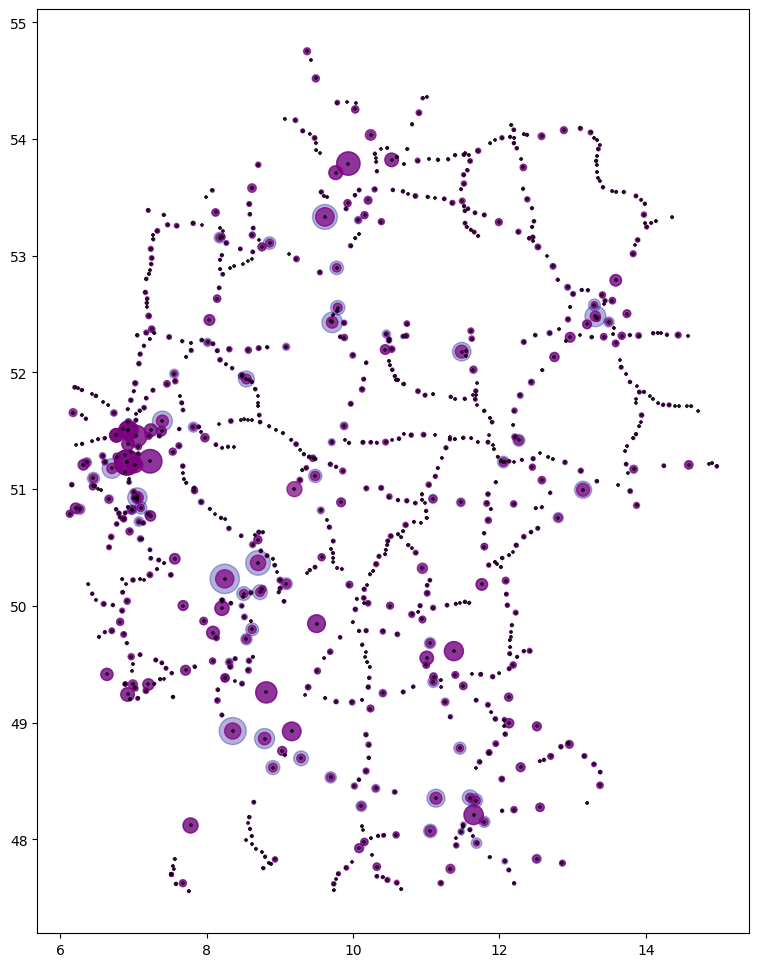

In [57]:
fig, ax = plt.subplots(figsize=(20, 12))

unfallorte.plot(ax=ax, markersize=10, alpha = 0.05, color="gray")
plt.scatter(unfallorte['lon'], unfallorte['lat'], s=unfallorte['cluster_si'], alpha=0.3, color="darkblue")
plt.scatter(unfallorte['lon'], unfallorte['lat'], s=unfallorte['normalized_cluster_size'], alpha=0.7, color="purple")
plt.scatter(unfallorte['lon'], unfallorte['lat'], alpha=0.7, s=5, color="black", marker="+")
plt.show()